## Introduction

### In this notebook we use [UNet](https://arxiv.org/abs/1505.04597) segmentation model for performing building segmentation

### Libraries 📚⬇

In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [2]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

### Defining train / val / test directories 📁

In [3]:
DATA_DIR = '/home/sara/Building-Segmentation-DL/data/'

# Define the paths
image_dir = '/home/sara/Building-Segmentation-DL/data/3band/'
ground_truth_dir = '/home/sara/Building-Segmentation-DL/data/buildingMaskLabels/'
text_dir = '/home/sara/Building-Segmentation-DL/data/dataSplit/'


# Define the names of the text files
text_files = ['test.txt', 'train.txt', 'val.txt']

# Define the names of the directories
dir_names = [ 'train', 'val', 'test']

# Read the text files
def split_images(image_dir, text_dir, text_files, dir_names):
    for text_file, dir_name in zip(text_files, dir_names):
        with open(os.path.join(text_dir, text_file), 'r') as file:
            image_names = file.read().splitlines()
            print(image_names)
    # Create the directory if it doesn't exist
        os.makedirs(os.path.join(image_dir, dir_name), exist_ok=True)

    # Iterate over the images in the image directory
        for image in os.listdir(image_dir):
            if image in image_names:
            # Move the image to the corresponding directory
                shutil.move(os.path.join(image_dir, image), os.path.join(image_dir, dir_name, image))

# split input images to test, train, and validation
split_images(image_dir, text_dir, text_files, dir_names)

# split ground truth images to test, train, and validation

split_images(ground_truth_dir, text_dir, text_files, dir_names)

x_train_dir = os.path.join(image_dir, dir_names[0])
y_train_dir = os.path.join(ground_truth_dir, dir_names[0])

x_valid_dir = os.path.join(image_dir, dir_names[1])
y_valid_dir = os.path.join(ground_truth_dir, dir_names[1])

x_test_dir = os.path.join(image_dir, dir_names[2])
y_test_dir = os.path.join(ground_truth_dir, dir_names[2])

['3band_AOI_1_RIO_img3962.tif', '3band_AOI_1_RIO_img6113.tif', '3band_AOI_1_RIO_img702.tif', '3band_AOI_1_RIO_img4005.tif', '3band_AOI_1_RIO_img2616.tif', '3band_AOI_1_RIO_img3225.tif', '3band_AOI_1_RIO_img4520.tif', '3band_AOI_1_RIO_img1248.tif', '3band_AOI_1_RIO_img5289.tif', '3band_AOI_1_RIO_img4056.tif', '3band_AOI_1_RIO_img795.tif', '3band_AOI_1_RIO_img5485.tif', '3band_AOI_1_RIO_img2955.tif', '3band_AOI_1_RIO_img6196.tif', '3band_AOI_1_RIO_img6385.tif', '3band_AOI_1_RIO_img6495.tif', '3band_AOI_1_RIO_img2751.tif', '3band_AOI_1_RIO_img4514.tif', '3band_AOI_1_RIO_img2727.tif', '3band_AOI_1_RIO_img6536.tif', '3band_AOI_1_RIO_img1212.tif', '3band_AOI_1_RIO_img2762.tif', '3band_AOI_1_RIO_img6323.tif', '3band_AOI_1_RIO_img6541.tif', '3band_AOI_1_RIO_img5409.tif', '3band_AOI_1_RIO_img2984.tif', '3band_AOI_1_RIO_img6823.tif', '3band_AOI_1_RIO_img6581.tif', '3band_AOI_1_RIO_img663.tif', '3band_AOI_1_RIO_img5121.tif', '3band_AOI_1_RIO_img1271.tif', '3band_AOI_1_RIO_img6191.tif', '3band_AOI

In [4]:
class_dict = pd.read_csv("./input/massachusetts-buildings-dataset/label_class_dict.csv")
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


#### Shortlist specific classes to segment

In [5]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'building']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'building']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


### Helper functions for viz. & one-hot encoding/decoding

In [6]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [7]:
class BuildingsDataset(torch.utils.data.Dataset):

    """Massachusetts Buildings Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
            type="None",
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.type = type
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
         # Resize the image to 1500 pixels
        # image = cv2.resize(image, (1500, 1500))
        # mask = cv2.resize(mask, (1500, 1500))

        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.type == "training":
            image = cv2.resize(image, (416, 416))
            mask = cv2.resize(mask, (416, 416))
        if self.type == "validation":
            image = cv2.resize(image, (480, 480))
            mask = cv2.resize(mask, (480, 480))
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

#### Visualize Sample Image and Mask 📈

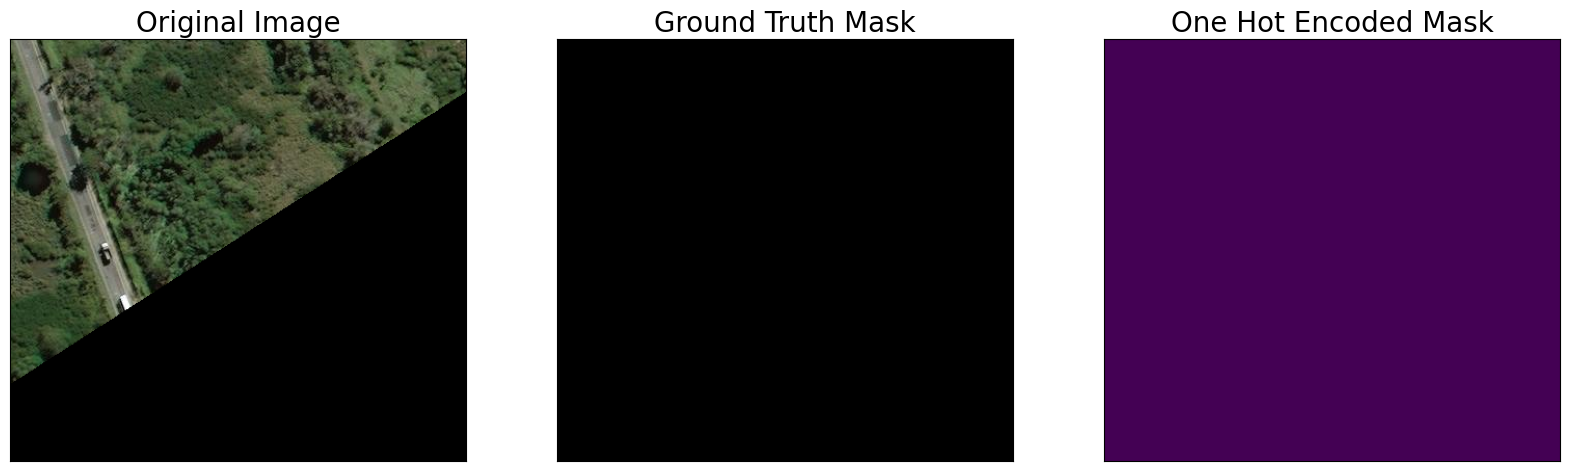

(406, 439, 3)


In [8]:
dataset = BuildingsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values, type="None")
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

print(image.shape)

### Defining Augmentations 🙃

In [9]:
def get_training_augmentation():
    train_transform = [    
        # album.resize(256, 256),
        # album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 16
    test_transform = [
        album.PadIfNeeded(min_height=480, min_width=480, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

#### Visualize Augmented Images & Masks

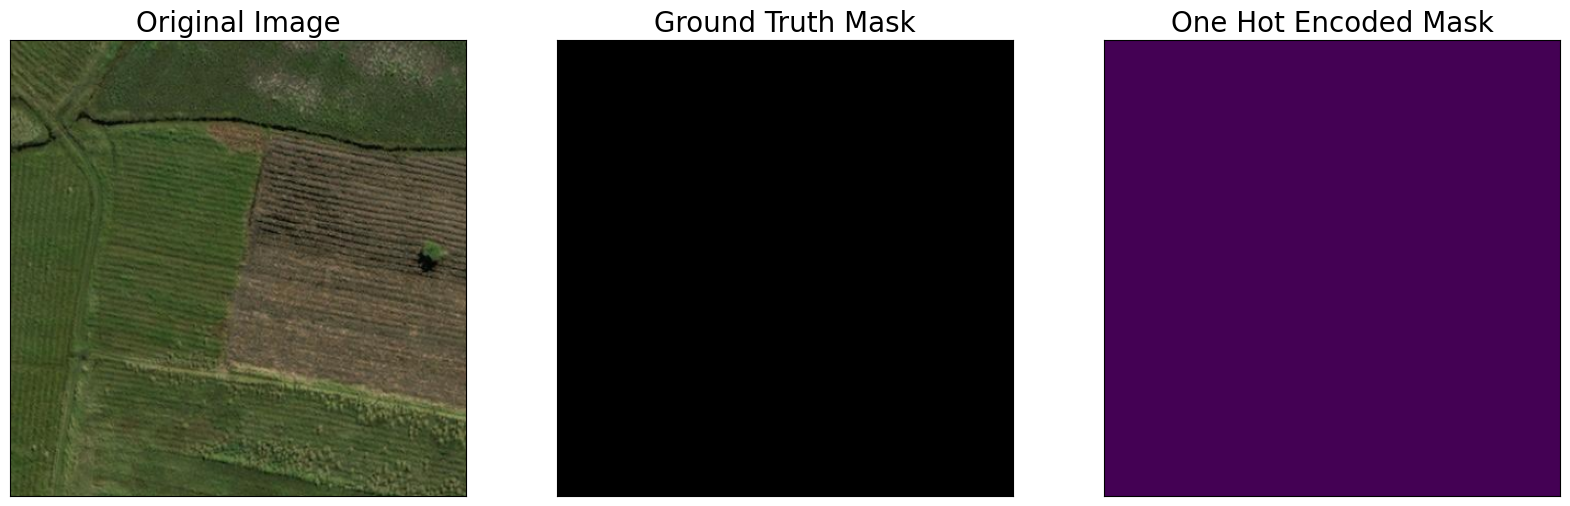

(416, 416, 3)


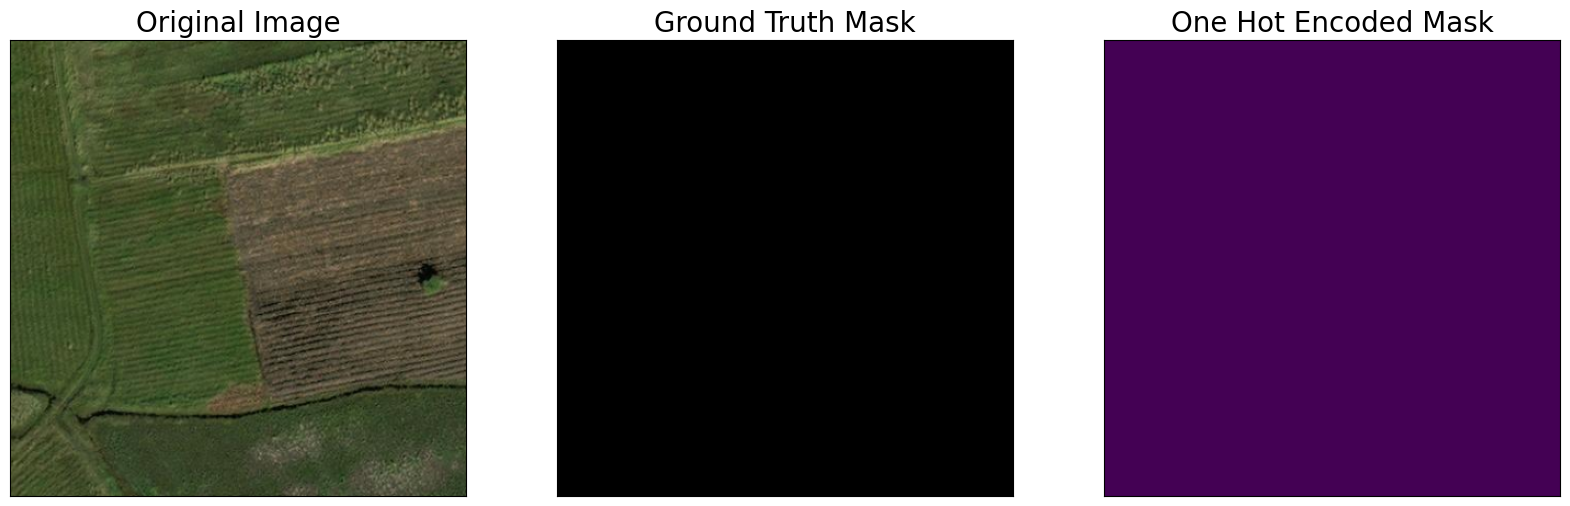

(416, 416, 3)


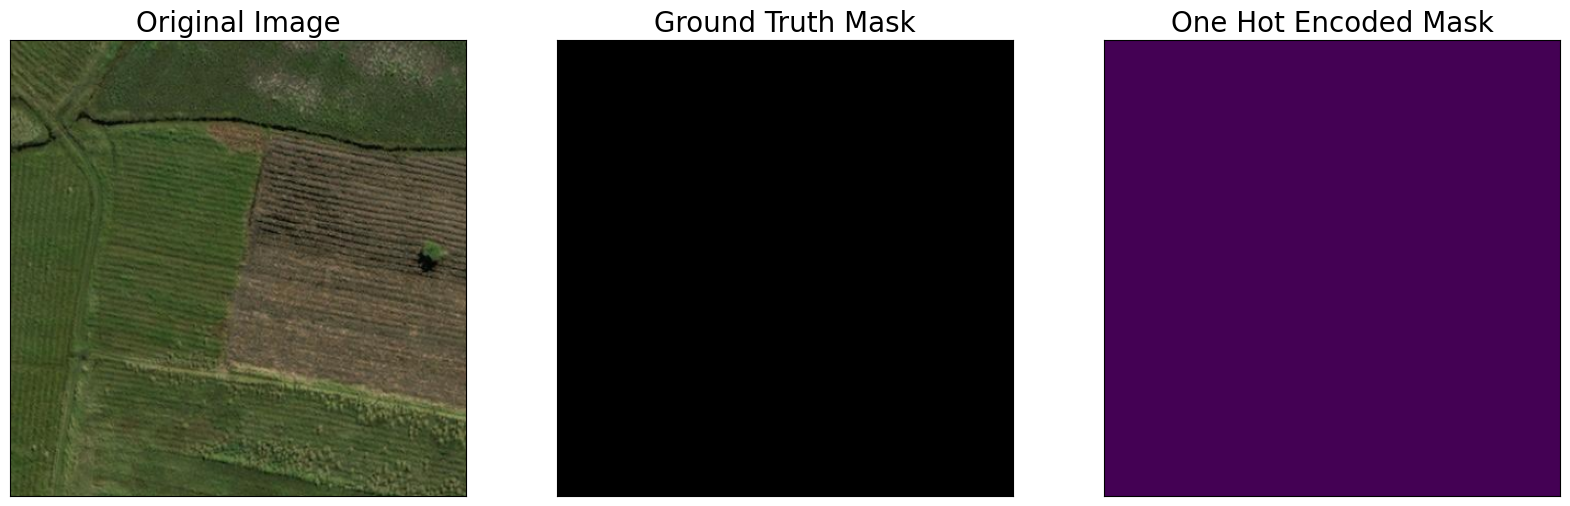

(416, 416, 3)


In [10]:
augmented_dataset = BuildingsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
    type="training"
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )
    print(image.shape)

## Training UNet

<h3><center>UNet Model Architecture</center></h3>
<img src="https://miro.medium.com/max/2824/1*f7YOaE4TWubwaFF7Z1fzNw.png" width="750" height="750"/>
<h4><center><a href="https://arxiv.org/abs/1505.04597">Image Courtesy: UNet [Ronneberger et al.]</a></center></h4>

### Altered Model Definition

In [11]:

class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi


In [79]:
# class DoubleConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(DoubleConv, self).__init__()
#         self.double_conv = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels//2, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(out_channels//2),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(int(out_channels//2), out_channels, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#         )

#     def forward(self, x):
#         return self.double_conv(x)
    
# class SingleConv3x1(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(SingleConv3x1, self).__init__()
#         self.single_conv = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#         )

#     def forward(self, x):
#         skip_out = self.single_conv(x)
#         return (skip_out, skip_out)

# class SingleConv4x2(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(SingleConv4x2, self).__init__()
#         self.single_conv = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         skip_out = self.single_conv(x)
#         return (skip_out, skip_out)
    
# class DownBlock(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(DownBlock, self).__init__()
#         self.double_conv = DoubleConv(in_channels, out_channels)

#     def forward(self, x):
#         skip_out = self.double_conv(x)
#         return (skip_out, skip_out)

    
# class UpBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, up_sample_mode):
#         super(UpBlock, self).__init__()
#         if up_sample_mode == 'conv_transpose':
#             self.up_sample = nn.Sequential(
#                 nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
#                 nn.BatchNorm2d(out_channels))
#         elif up_sample_mode == 'bilinear':
#             self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#         else:
#             raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")

#         self.conv = SingleConv3x1(out_channels, int(out_channels//2))


#     def forward(self, skip_input, down_input):
#         x = self.up_sample(torch.cat([skip_input, down_input], dim=1))
#         return self.conv(x)

    
# class UNet(nn.Module):
#     def __init__(self, out_classes=2, up_sample_mode='conv_transpose'):
#         super(UNet, self).__init__()
#         self.up_sample_mode = up_sample_mode

#         # Downsampling Path
#         self.down_conv1 = SingleConv3x1(3, 32)
#         self.down_conv2 = SingleConv4x2(32, 64)
#         self.down_conv3 = SingleConv3x1(64, 64)
#         self.down_conv4 = SingleConv4x2(64, 128)
#         self.down_conv5 = SingleConv3x1(128, 128)
#         self.down_conv6 = SingleConv4x2(128, 256)
#         self.down_conv7 = SingleConv3x1(256, 256)
#         self.down_conv8 = SingleConv4x2(256, 512)

#         # Bottleneck
#         self.bottleneck_conv = SingleConv3x1(512, 512)

#         # Upsampling Path
#         self.up_conv4 = UpBlock(1024, 512, self.up_sample_mode)
#         self.up_conv3 = UpBlock(512, 256, self.up_sample_mode)
#         self.up_conv2 = UpBlock(256, 128, self.up_sample_mode)
#         self.up_conv1 = UpBlock(128, 64, self.up_sample_mode)

#         # Final Convolution
#         self.conv_last = nn.Conv2d(64, out_classes, kernel_size=3, stride=1, padding=1)

#     def forward(self, x):

#         x, skip1_out = self.down_conv1(x)
#         x, _ = self.down_conv2(x)
#         x, skip3_out = self.down_conv3(x)
#         x, _ = self.down_conv4(x)
#         x, skip5_out = self.down_conv5(x)
#         x, _ = self.down_conv6(x)
#         x, skip7_out = self.down_conv7(x)
#         x, skip8_out = self.down_conv8(x)
    
#         x, _ = self.bottleneck_conv(x)

#         print(skip8_out.shape, x.shape)
#         x, _ = self.up_conv4(skip8_out, x)
#         x, _ = self.up_conv3(skip7_out, x)
#         x, _ = self.up_conv2(skip5_out, x)
#         x, _ = self.up_conv1(skip3_out, x)
#         x = self.conv_last(torch.cat([skip1_out, x], dim=1))

#         return x
    
# # Get UNet model
# model = UNet()

In [104]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels//2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels//2),
            nn.ReLU(inplace=True),
            nn.Conv2d(int(out_channels//2), out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
class SingleConv3x1(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SingleConv3x1, self).__init__()
        self.single_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        skip_out = self.single_conv(x)
        return (skip_out, skip_out)

class SingleConv4x2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SingleConv4x2, self).__init__()
        self.single_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        skip_out = self.single_conv(x)
        return (skip_out, skip_out)
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, x):
        skip_out = self.double_conv(x)
        return (skip_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(out_channels))
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")

        self.conv = SingleConv3x1(out_channels, int(out_channels//2))


    def forward(self, skip_input, down_input):
        x = self.up_sample(torch.cat([skip_input, down_input], dim=1))
        return self.conv(x)

    
class UNet(nn.Module):
    def __init__(self, out_classes=2, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode

        # Downsampling Path
        self.down_conv1 = SingleConv3x1(3, 32)
        self.down_conv2 = SingleConv4x2(32, 64)
        self.down_conv3 = SingleConv3x1(64, 64)
        self.down_conv4 = SingleConv4x2(64, 128)
        self.down_conv5 = SingleConv3x1(128, 128)
        self.down_conv6 = SingleConv4x2(128, 256)
        self.down_conv7 = SingleConv3x1(256, 256)
        self.down_conv8 = SingleConv4x2(256, 512)

        # Bottleneck
        self.bottleneck_conv = SingleConv3x1(512, 512)

        # Upsampling Path
        self.Att4 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.up_conv4 = UpBlock(1024, 512, self.up_sample_mode)

        self.Att3 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.up_conv3 = UpBlock(512, 256, self.up_sample_mode)

        self.Att2 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.up_conv2 = UpBlock(256, 128, self.up_sample_mode)

        self.Att1 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.up_conv1 = UpBlock(128, 64, self.up_sample_mode)

        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=3, stride=1, padding=1)

    def forward(self, x):

        x, skip1_out = self.down_conv1(x)
        x, _ = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, _ = self.down_conv4(x)
        x, skip5_out = self.down_conv5(x)
        x, _ = self.down_conv6(x)
        x, skip7_out = self.down_conv7(x)
        x, skip8_out = self.down_conv8(x)
    
        x, _ = self.bottleneck_conv(x)

        skip8_out = self.Att4(g = x, x=skip8_out)
        x, _ = self.up_conv4(skip8_out, x)

        skip7_out = self.Att3(g = x, x=skip7_out)
        x, _ = self.up_conv3(skip7_out, x)

        skip5_out = self.Att2(g = x, x=skip5_out)
        x, _ = self.up_conv2(skip5_out, x)

        skip3_out = self.Att1(g = x, x=skip3_out)
        x, _ = self.up_conv1(skip3_out, x)
        x = self.conv_last(torch.cat([skip1_out, x], dim=1))

        return x
    
# Get UNet model
model = UNet()

#### Get Train / Val DataLoaders

In [105]:
# Get train and val dataset instances
train_dataset = BuildingsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
    type="training",
)

valid_dataset = BuildingsDataset(
    x_valid_dir, y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
    type="validation",
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

print(valid_dataset[0][0].shape)
print(train_dataset[0][0].shape)
print(len(train_dataset))

(3, 480, 480)
(3, 416, 416)
4858


#### Set Hyperparams

In [106]:
from segmentation_models_pytorch import utils


# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 40

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:" , DEVICE)

# define loss function
bceloss = torch.nn.BCELoss()

loss = smp.utils.losses.BCEWithLogitsLoss()
# loss = bceloss

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
    smp.utils.metrics.Accuracy(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00008),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# # load best saved model checkpoint from previous commit (if present)
# if os.path.exists('../input/unet-for-building-segmentation-pytorch/best_model.pth'):
#     model = torch.load('../input/unet-for-building-segmentation-pytorch/best_model.pth', map_location=DEVICE)

DEVICE: cuda


In [107]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

### Training UNet

In [108]:
models_folder = 'models/'
if not os.path.exists(models_folder):
    os.makedirs(models_folder)

In [109]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './models/attention_model{}.pth'.format(i))
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 694/694 [00:33<00:00, 20.45it/s, bce_with_logits_loss - 0.1476, iou_score - 0.8807, fscore - 0.9276, accuracy - 0.9242]
Model saved!

Epoch: 1
valid: 100%|██████████| 694/694 [00:34<00:00, 20.39it/s, bce_with_logits_loss - 0.1204, iou_score - 0.898, fscore - 0.9402, accuracy - 0.9362] 
Model saved!

Epoch: 2
valid: 100%|██████████| 694/694 [00:34<00:00, 20.39it/s, bce_with_logits_loss - 0.1202, iou_score - 0.9006, fscore - 0.9419, accuracy - 0.9375]
Model saved!

Epoch: 3
valid: 100%|██████████| 694/694 [00:34<00:00, 20.39it/s, bce_with_logits_loss - 0.127, iou_score - 0.8941, fscore - 0.9374, accuracy - 0.933]  

Epoch: 4
valid: 100%|██████████| 694/694 [00:34<00:00, 20.34it/s, bce_with_logits_loss - 0.1221, iou_score - 0.8939, fscore - 0.9377, accuracy - 0.9342] 

Epoch: 5
valid: 100%|██████████| 694/694 [00:34<00:00, 20.30it/s, bce_with_logits_loss - 0.1122, iou_score - 0.9043, fscore - 0.9446, accuracy - 0.94]  
Model saved!

Epoch: 6
valid: 100%|█

### Prediction on Test Data

In [110]:
# load best saved model checkpoint from the current run
if os.path.exists('./models/attention_model39.pth'):
    best_model = torch.load('./models/attention_model39.pth', map_location=DEVICE)
    print('Loaded UNet model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('../input/unet-for-building-segmentation-pytorch/best_model.pth'):
    best_model = torch.load('../input/unet-for-building-segmentation-pytorch/best_model.pth', map_location=DEVICE)
    print('Loaded UNet model from a previous commit.')

Loaded UNet model from this run.


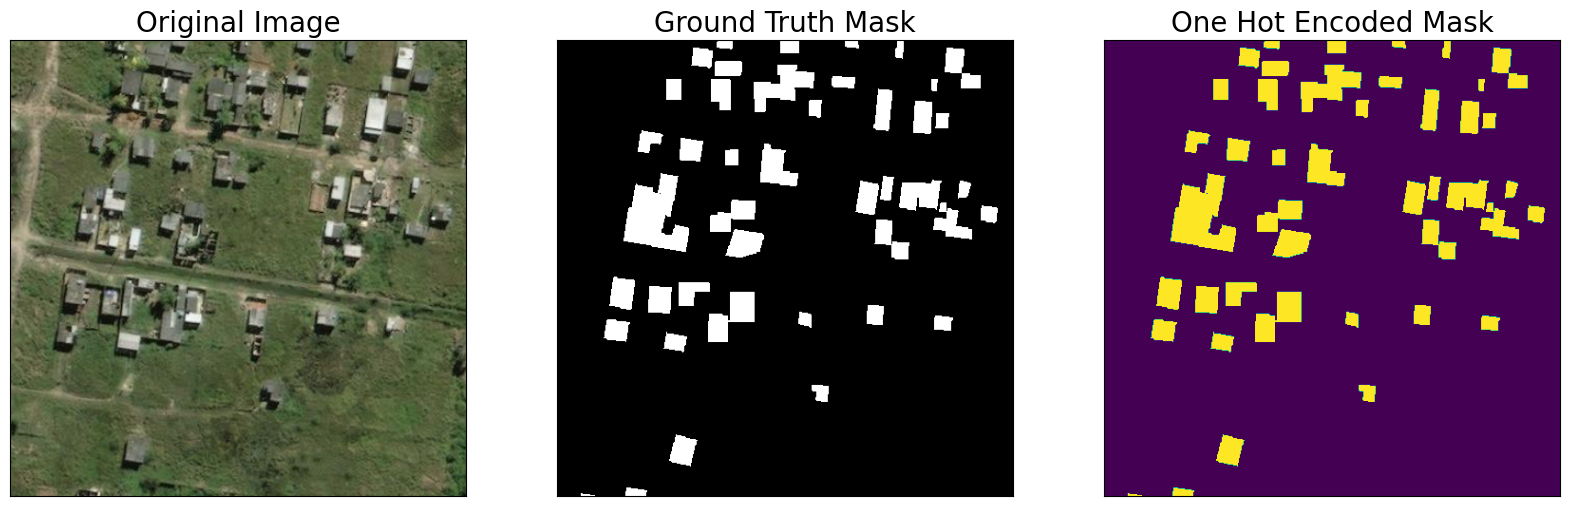

In [111]:
# create test dataloader to be used with UNet model (with preprocessing operation: to_tensor(...))
test_dataset = BuildingsDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
    type="validation",
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = BuildingsDataset(
    x_test_dir, y_test_dir, 
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
    type="validation",
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

# Notice the images / masks are 1536*1536 because of 18px padding on all sides. 
# This is to ensure the input image dimensions to UNet model are a multiple of 2 (to account for pooling & transpose conv. operations).

In [112]:
# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[1500,1500,3]):
   
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [113]:
sample_preds_folder = 'attention_sample_preds/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [115]:
for idx in range(len(test_dataset)):

    random_idx = random.randint(0, len(test_dataset)-1)
    image, gt_mask = test_dataset[random_idx]
    image_vis = crop_image(test_dataset_vis[random_idx][0].astype('uint8'))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to building
    pred_building_heatmap = pred_mask[:,:,select_classes.index('building')]
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    # visualize(
    #     original_image = image_vis,
    #     ground_truth_mask = gt_mask,
    #     predicted_mask = pred_mask,
    #     predicted_building_heatmap = pred_building_heatmap
    # )

### Model Evaluation on Test Dataset

In [116]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean BCE Loss: {valid_logs['bce_with_logits_loss']:.4f}")

valid: 100%|██████████| 1388/1388 [01:41<00:00, 13.62it/s, bce_with_logits_loss - 0.09903, iou_score - 0.9144, fscore - 0.951, accuracy - 0.9457] 
Evaluation on Test Data: 
Mean IoU Score: 0.9144
Mean BCE Loss: 0.0990


### Plot Dice Loss & IoU Metric for Train vs. Val

In [117]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
bce_with_logits_loss,0.205929,0.139825,0.129793,0.126197,0.123181,0.122904,0.118976,0.118060,0.114760,0.115099,...,0.103245,0.103762,0.102485,0.102599,0.103913,0.101163,0.101733,0.101457,0.103029,0.100730
iou_score,0.842803,0.879630,0.886511,0.887984,0.890990,0.891409,0.893839,0.895106,0.897152,0.896819,...,0.906316,0.906136,0.907065,0.907263,0.906281,0.908107,0.907715,0.908126,0.906660,0.908623
fscore,0.908908,0.934330,0.938396,0.939277,0.941003,0.941093,0.942658,0.943294,0.944516,0.944310,...,0.949743,0.949662,0.950172,0.950234,0.949654,0.950735,0.950445,0.950712,0.949957,0.951023
accuracy,0.907998,0.928398,0.932236,0.933106,0.934718,0.934864,0.936309,0.936919,0.938077,0.937896,...,0.943019,0.942926,0.943422,0.943487,0.942954,0.943970,0.943716,0.943954,0.943198,0.944231


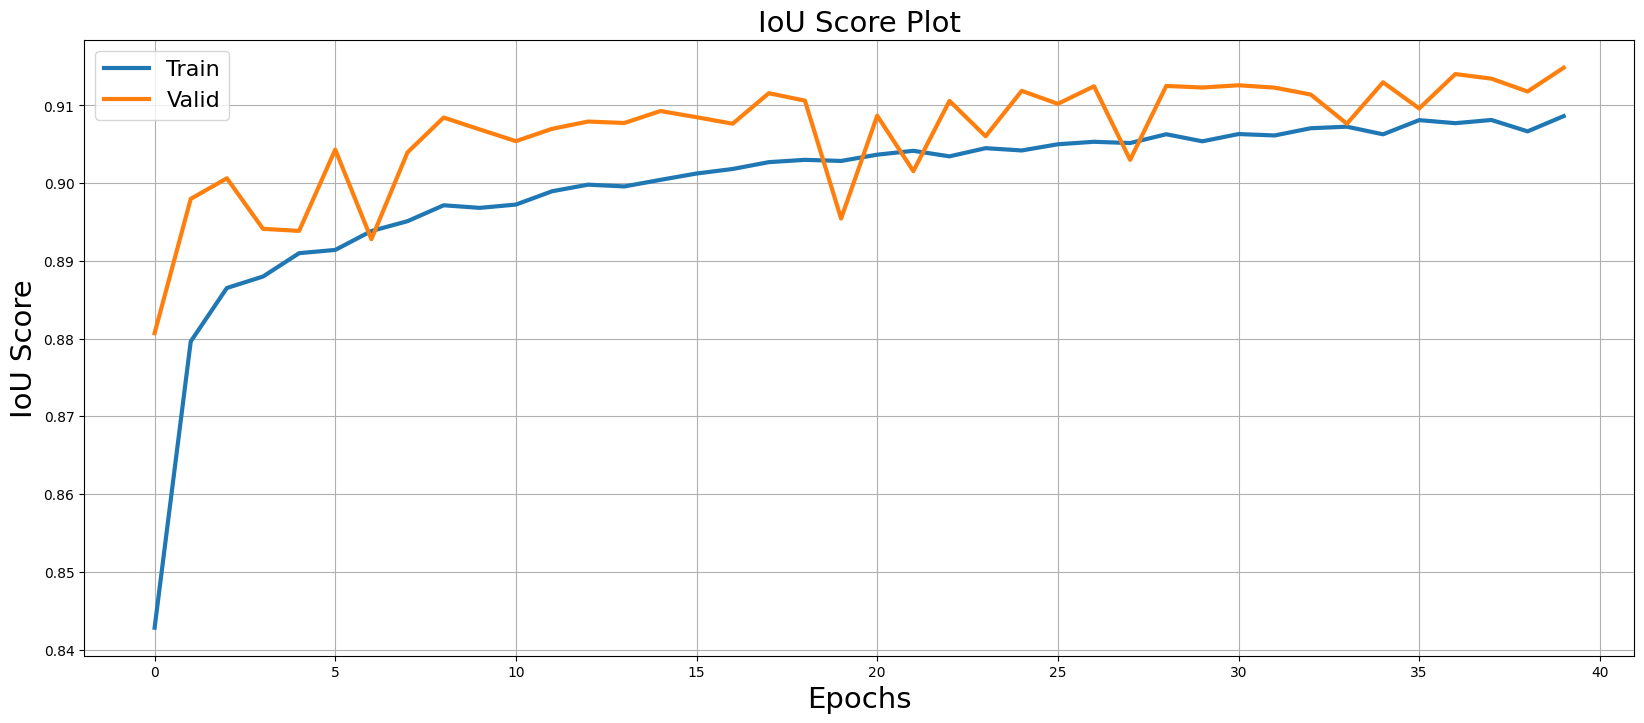

In [118]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('IoU Score', fontsize=21)
plt.title('IoU Score Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('attention_iou_score_plot.png')
plt.show()

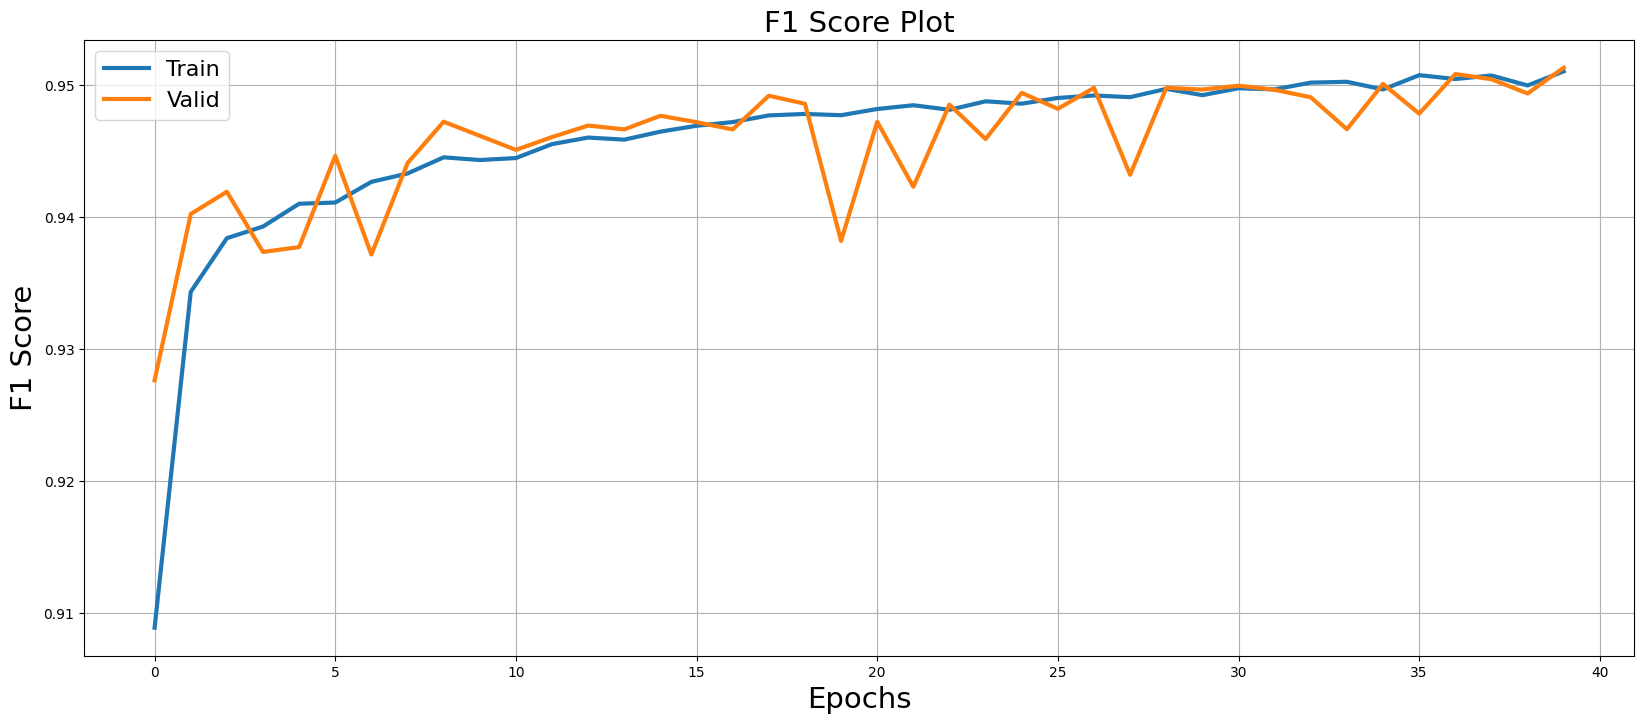

In [119]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.fscore.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.fscore.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('F1 Score', fontsize=21)
plt.title('F1 Score Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('attention_f1_score_plot.png')
plt.show()

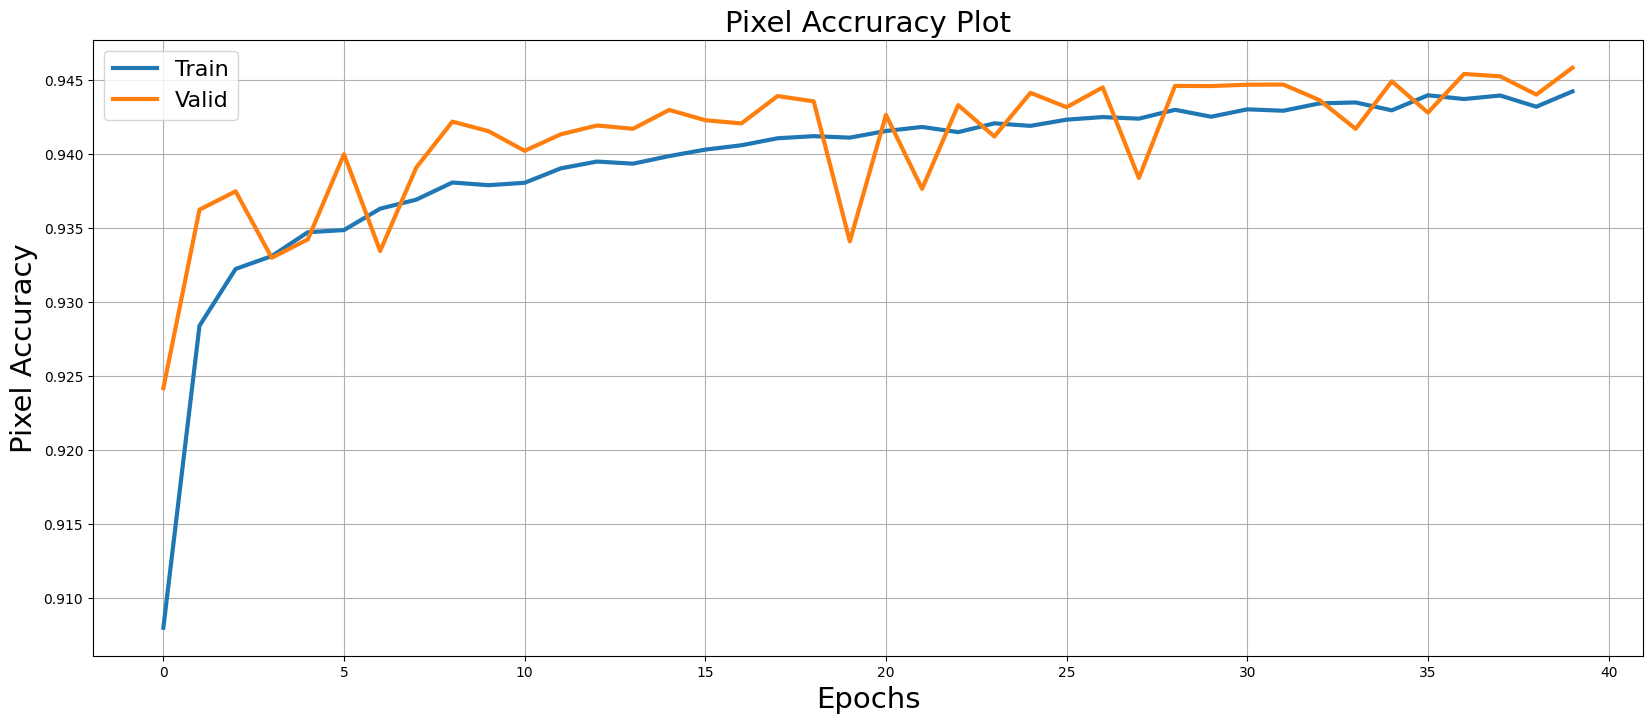

In [120]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.accuracy.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.accuracy.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('Pixel Accuracy', fontsize=21)
plt.title('Pixel Accruracy Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('attention_paccuracy_plot.png')
plt.show()